<a href="https://colab.research.google.com/github/kommurisi/Individual_SiddiKommuri_HandlingMissingData-Titanic/blob/main/Siddi_WorkedExamplesAirline_002374754.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Course in Forecasting — Worked Examples

This notebook contains **two worked examples** following the same pipeline:
EDA → baselines → ETS (Holt–Winters) → compact SARIMA grid search → residual diagnostics → scoreboard → final forecast with prediction intervals.

**Datasets**
1) **Airline Passengers (monthly)** — classic strong trend + multiplicative seasonality  
2) **Champagne Sales (monthly)** — shorter series, clear seasonality with quirks (zeros/missings)

All code is Colab-friendly and uses `pandas`, `seaborn`, and `statsmodels`. No exotic installs.


In [1]:
# === Common imports & helpers used by both examples ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools, warnings

sns.set_theme(style="whitegrid")
%matplotlib inline
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# version-safe RMSE + scorer
def _rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

def score(y_true, y_pred, name):
    y_true = y_true.reindex(y_pred.index)
    mask = ~y_pred.isna()
    y_true = y_true[mask]; y_pred = y_pred[mask]
    return pd.Series({"Model": name,
                      "MAE": mean_absolute_error(y_true, y_pred),
                      "RMSE": _rmse(y_true, y_pred),
                      "MAPE%": mape(y_true, y_pred)})

def residual_diagnostics(residuals, idx=None, lags=24, title="Residuals"):
    resid = pd.Series(residuals, index=idx) if idx is not None else pd.Series(residuals)
    fig, axes = plt.subplots(2,2,figsize=(12,7))
    resid.plot(ax=axes[0,0], title=f"{title} — Series")
    sns.histplot(resid, ax=axes[0,1], kde=True); axes[0,1].set_title("Histogram")
    plot_acf(resid.dropna(), lags=lags, ax=axes[1,0])
    plot_pacf(resid.dropna(), lags=lags, ax=axes[1,1], method='ywm')
    plt.tight_layout(); plt.show()
    lb = acorr_ljungbox(resid.dropna(), lags=[12,24], return_df=True)
    print("Ljung–Box p-values:\n", lb[["lb_stat","lb_pvalue"]])

# compact, robust SARIMA search (returns best_model, best_order, best_seasonal)
def sarima_search(y_train, seasonal_period=12, grid_small=True):
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
    p = d = q = [0,1,2] if grid_small else [0,1,2,3]
    P = D = Q = [0,1]
    m = seasonal_period

    best_model, best_aic = None, np.inf
    best_order, best_seasonal = None, None
    tried = []

    def try_fit(order, sorder):
        for method, it in [("lbfgs", 1000), ("powell", 300)]:
            try:
                mdl = SARIMAX(
                    y_train, order=order,
                    seasonal_order=(sorder[0], sorder[1], sorder[2], m),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend="n",
                ).fit(disp=False, method=method, maxiter=it)
                return mdl
            except Exception:
                continue
        return None

    for order in itertools.product(p,d,q):
        for sorder in itertools.product(P,D,Q):
            mdl = try_fit(order, sorder)
            aic = mdl.aic if mdl is not None else np.inf
            tried.append((order, sorder, aic))
            if aic < best_aic:
                best_model, best_aic = mdl, aic
                best_order = order
                best_seasonal = (sorder[0], sorder[1], sorder[2], m)

    tried_df = pd.DataFrame(tried, columns=["order","seasonal_order","AIC"]).sort_values("AIC")
    return best_model, best_order, best_seasonal, tried_df


# Worked Example 1 — Airline Passengers (Monthly)

**Question.** Forecast the next 12 months of airline passengers.  
**Characteristics.** Strong upward trend + multiplicative seasonality (monthly).  
**Plan.** EDA → baselines → ETS (Holt–Winters) → SARIMA search → diagnostics → final forecast (12 months) with PIs.


In [3]:
# Core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, Holt

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

import itertools, warnings
sns.set_theme(style="whitegrid")
%matplotlib inline
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# ---------- Scoring helpers ----------
def _rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)).mean() * 100

def score(y_true, y_pred, name):
    y_true = y_true.reindex(y_pred.index)
    mask = ~y_pred.isna()
    y_true = y_true[mask]; y_pred = y_pred[mask]
    return pd.Series({"Model": name,
                      "MAE": mean_absolute_error(y_true, y_pred),
                      "RMSE": _rmse(y_true, y_pred),
                      "MAPE%": mape(y_true, y_pred)})

# ---------- Residual diagnostics ----------
def residual_diagnostics(residuals, idx=None, lags=24, title="Residuals"):
    resid = pd.Series(residuals, index=idx) if idx is not None else pd.Series(residuals)
    fig, axes = plt.subplots(2,2, figsize=(12,7))
    resid.plot(ax=axes[0,0], title=f"{title} — Series")
    sns.histplot(resid, ax=axes[0,1], kde=True); axes[0,1].set_title("Histogram")
    plot_acf(resid.dropna(), lags=lags, ax=axes[1,0])
    plot_pacf(resid.dropna(), lags=lags, ax=axes[1,1], method='ywm')
    plt.tight_layout(); plt.show()
    lb = acorr_ljungbox(resid.dropna(), lags=[12,24], return_df=True)
    print("Ljung–Box p-values:\n", lb[["lb_stat","lb_pvalue"]])

# ---------- Compact SARIMA search ----------
def sarima_search(y_train, seasonal_period=12, grid_small=True):
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
    p = d = q = [0,1,2] if grid_small else [0,1,2,3]
    P = D = Q = [0,1]
    m = seasonal_period

    best_model = None
    best_aic = np.inf
    best_order = None
    best_seasonal = None
    tried = []

    def try_fit(order, sorder):
        for method, it in [("lbfgs", 1000), ("powell", 300)]:
            try:
                mdl = SARIMAX(
                    y_train, order=order,
                    seasonal_order=(sorder[0], sorder[1], sorder[2], m),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                    trend="n",
                ).fit(disp=False, method=method, maxiter=it)
                return mdl
            except Exception:
                continue
        return None

    for order in itertools.product(p,d,q):
        for sorder in itertools.product(P,D,Q):
            mdl = try_fit(order, sorder)
            aic = mdl.aic if mdl is not None else np.inf
            tried.append((order, sorder, aic))
            if aic < best_aic:
                best_model, best_aic = mdl, aic
                best_order = order
                best_seasonal = (sorder[0], sorder[1], sorder[2], m)

    tried_df = pd.DataFrame(tried, columns=["order","seasonal_order","AIC"]).sort_values("AIC")
    return best_model, best_order, best_seasonal, tried_df


In [4]:
# Option A: seaborn 'flights' (recommended; same dataset)
try:
    flights = sns.load_dataset("flights").rename(columns={"passengers":"Passengers", "month":"Month"})
    flights["Month"] = pd.to_datetime(flights["year"].astype(str) + "-" + flights["Month"])
    data1 = flights[["Month","Passengers"]].set_index("Month").asfreq("MS")
except Exception:
    # Option B: fallback URL
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url)
    df["Month"] = pd.to_datetime(df["Month"])
    data1 = df.set_index("Month").rename(columns={"Passengers":"Passengers"}).asfreq("MS")

y1 = data1["Passengers"].astype(float)
print(y1.head(), "\n\nfreq:", y1.index.freq)


Month
1949-01-01   112.000
1949-02-01   118.000
1949-03-01   132.000
1949-04-01   129.000
1949-05-01   121.000
Freq: MS, Name: Passengers, dtype: float64 

freq: <MonthBegin>


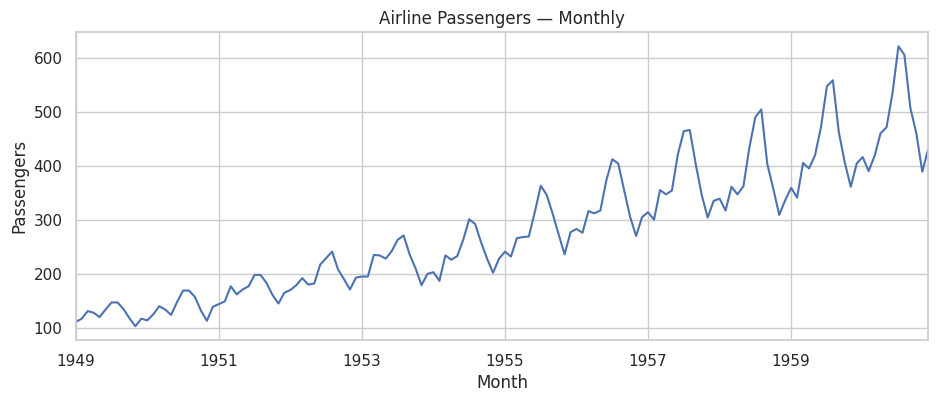

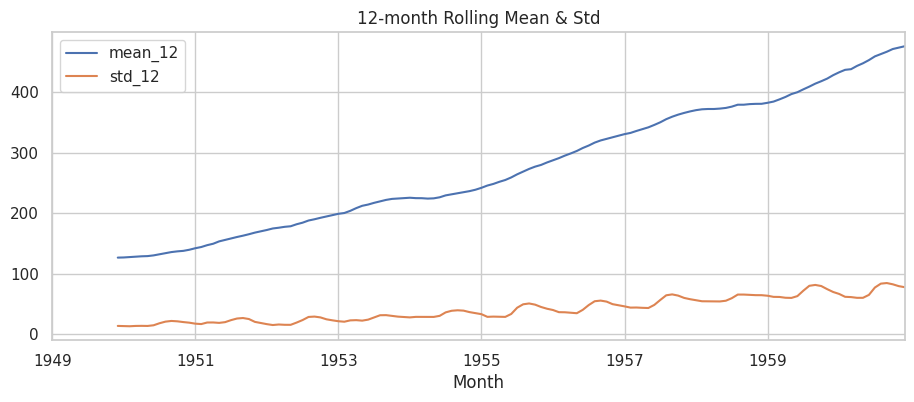

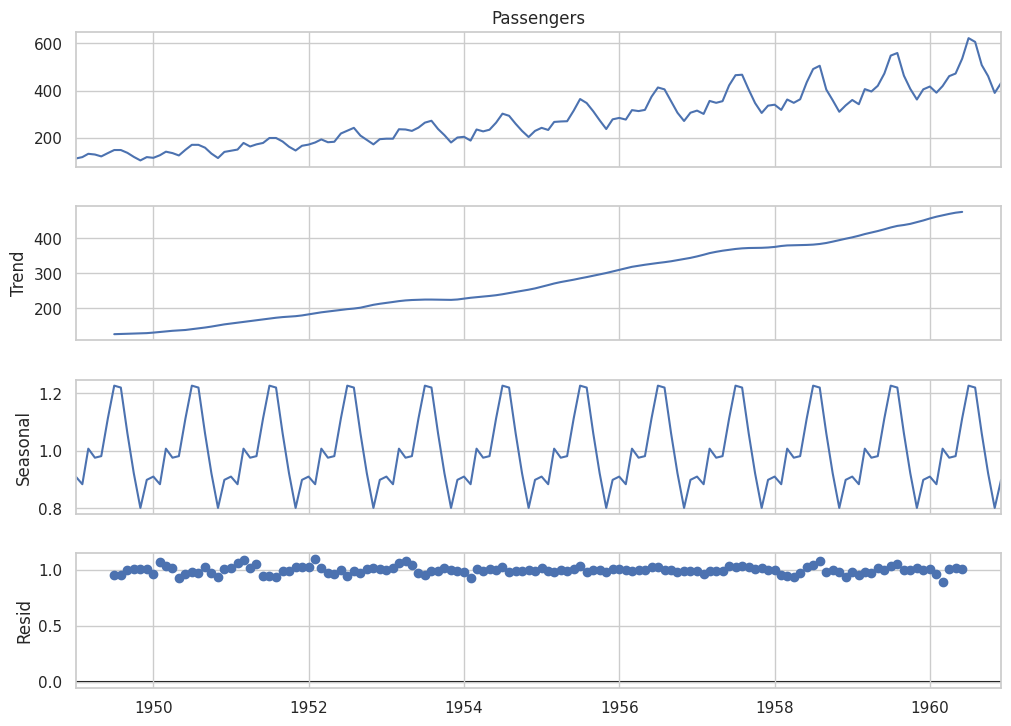

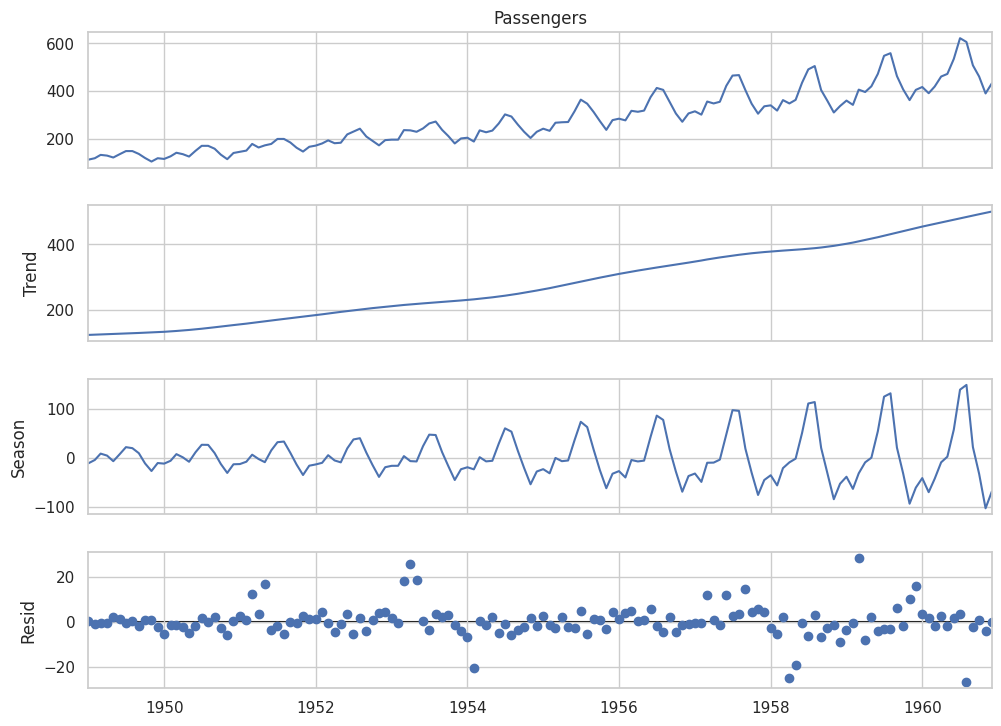

In [5]:
fig, ax = plt.subplots(1,1, figsize=(11,4))
y1.plot(ax=ax); ax.set_title("Airline Passengers — Monthly"); ax.set_ylabel("Passengers"); plt.show()

pd.DataFrame({"mean_12": y1.rolling(12).mean(),
              "std_12":  y1.rolling(12).std()}).plot(figsize=(11,4), title="12-month Rolling Mean & Std"); plt.show()

seasonal = seasonal_decompose(y1, model="multiplicative", period=12)
seasonal.plot(); plt.gcf().set_size_inches(11,8); plt.show()

STL(y1, period=12, robust=True).fit().plot(); plt.gcf().set_size_inches(11,8); plt.show()


,Model,MAE,RMSE,MAPE%
1,Seasonal Naive,47.583,49.987,10.523
2,Moving Avg (12),77.833,103.215,15.473
0,Naive,115.250,137.329,23.577


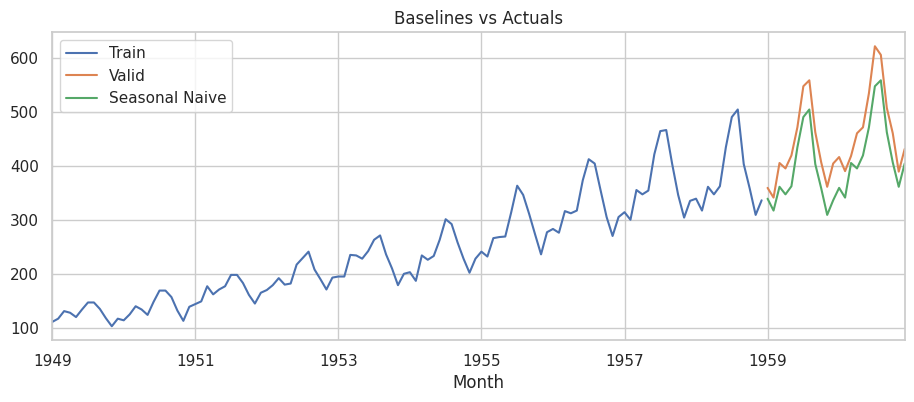

In [6]:
h1 = 24
y1_tr, y1_va = y1.iloc[:-h1], y1.iloc[-h1:]

naive1  = pd.Series(y1_tr.iloc[-1], index=y1_va.index)
snaive1 = y1.shift(12).reindex(y1_va.index)     # use full series for shift(12)
ma1     = pd.Series(y1_tr.rolling(12).mean().iloc[-1], index=y1_va.index)

baseline_scores1 = pd.concat([
    score(y1_va, naive1, "Naive"),
    score(y1_va, snaive1, "Seasonal Naive"),
    score(y1_va, ma1, "Moving Avg (12)")
], axis=1).T

display(baseline_scores1.sort_values("RMSE"))

plt.figure(figsize=(11,4))
y1_tr.plot(label="Train"); y1_va.plot(label="Valid"); snaive1.plot(label="Seasonal Naive")
plt.title("Baselines vs Actuals"); plt.legend(); plt.show()


,Model,MAE,RMSE,MAPE%
1,"HW (mul trend, mul seas)",12.380,13.878,2.813
2,"HW (mul trend, add seas)",15.593,18.411,3.291
0,Holt (exp trend),70.177,93.932,14.001


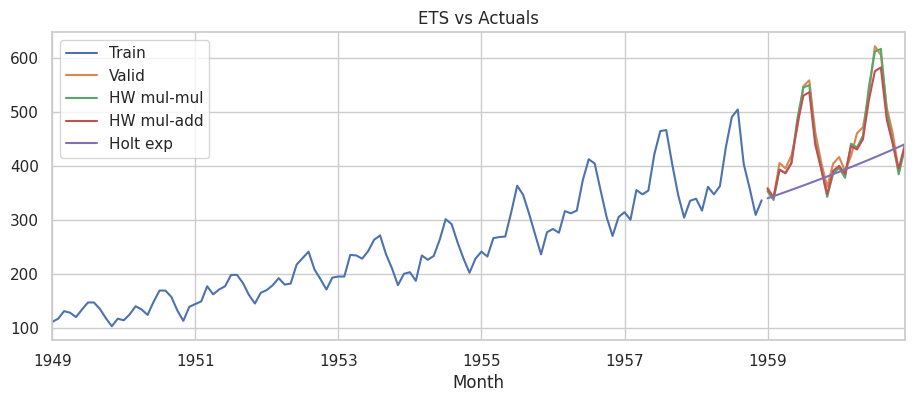

In [7]:
ets_scores1 = []

holt1 = Holt(y1_tr, exponential=True).fit()
pred_holt1 = holt1.forecast(h1)
ets_scores1.append(score(y1_va, pred_holt1, "Holt (exp trend)"))

hw_mm1 = ExponentialSmoothing(y1_tr, trend="mul", seasonal="mul", seasonal_periods=12).fit()
pred_hw_mm1 = hw_mm1.forecast(h1)
ets_scores1.append(score(y1_va, pred_hw_mm1, "HW (mul trend, mul seas)"))

hw_ma1 = ExponentialSmoothing(y1_tr, trend="mul", seasonal="add", seasonal_periods=12).fit()
pred_hw_ma1 = hw_ma1.forecast(h1)
ets_scores1.append(score(y1_va, pred_hw_ma1, "HW (mul trend, add seas)"))

ets_scores1 = pd.DataFrame(ets_scores1).sort_values("RMSE")
display(ets_scores1)

plt.figure(figsize=(11,4))
y1_tr.plot(label="Train"); y1_va.plot(label="Valid")
pred_hw_mm1.plot(label="HW mul-mul"); pred_hw_ma1.plot(label="HW mul-add"); pred_holt1.plot(label="Holt exp")
plt.title("ETS vs Actuals"); plt.legend(); plt.show()


,order,seasonal_order,AIC
67,"(0, 2, 2)","(0, 1, 1)",696.637
139,"(1, 2, 2)","(0, 1, 1)",697.902
71,"(0, 2, 2)","(1, 1, 1)",698.636
211,"(2, 2, 2)","(0, 1, 1)",699.886
143,"(1, 2, 2)","(1, 1, 1)",699.901
187,"(2, 1, 2)","(0, 1, 1)",700.922
47,"(0, 1, 2)","(1, 1, 1)",700.924
191,"(2, 1, 2)","(1, 1, 1)",700.926
215,"(2, 2, 2)","(1, 1, 1)",701.886
119,"(1, 1, 2)","(1, 1, 1)",702.482


,0
Model,"SARIMA (0, 2, 2) x (0, 1, 1, 12)"
MAE,67.664
RMSE,73.359
MAPE%,14.715


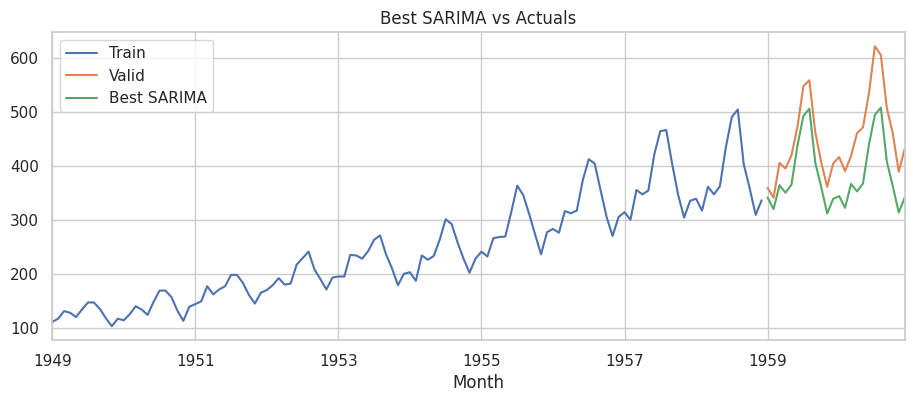

In [8]:
best_sarima1, best_order1, best_seasonal1, tried1 = sarima_search(y1_tr, seasonal_period=12)
display(tried1.head(10))

if best_sarima1 is None:
    print("No SARIMA converged; using ETS only.")
    sarima_pred1 = None
    sarima_score1 = None
else:
    sarima_pred1 = best_sarima1.forecast(h1)
    sarima_score1 = score(y1_va, sarima_pred1, f"SARIMA {best_order1} x {best_seasonal1}")
    display(sarima_score1)

    plt.figure(figsize=(11,4))
    y1_tr.plot(label="Train"); y1_va.plot(label="Valid"); sarima_pred1.plot(label="Best SARIMA")
    plt.title("Best SARIMA vs Actuals"); plt.legend(); plt.show()


,Model,MAE,RMSE,MAPE%
0,"HW (mul trend, mul seas)",12.380,13.878,2.813
1,"HW (mul trend, add seas)",15.593,18.411,3.291
2,Seasonal Naive,47.583,49.987,10.523
3,"SARIMA (0, 2, 2) x (0, 1, 1, 12)",67.664,73.359,14.715
4,Holt (exp trend),70.177,93.932,14.001
5,Moving Avg (12),77.833,103.215,15.473
6,Naive,115.250,137.329,23.577


Diagnostics: HW mul-mul


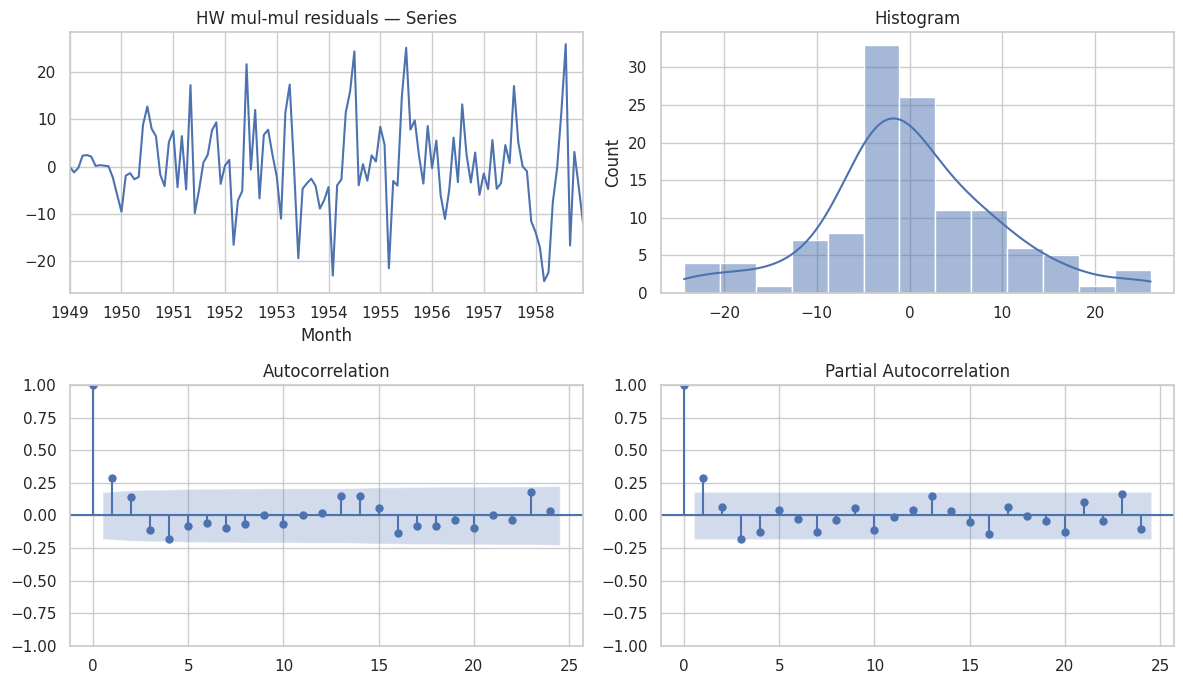

Ljung–Box p-values:
     lb_stat  lb_pvalue
12   21.950      0.038
24   39.830      0.022


In [9]:
cands1 = [baseline_scores1, ets_scores1]
if sarima_score1 is not None:
    cands1.append(pd.DataFrame([sarima_score1]))
scoreboard1 = pd.concat(cands1).sort_values("RMSE").reset_index(drop=True)
display(scoreboard1)

if sarima_score1 is not None and scoreboard1.iloc[0]["Model"].startswith("SARIMA"):
    print("Diagnostics: SARIMA")
    residual_diagnostics(best_sarima1.resid, idx=y1_tr.index, lags=24, title="SARIMA residuals")
else:
    print("Diagnostics: HW mul-mul")
    residual_diagnostics(hw_mm1.resid, idx=y1_tr.index, lags=24, title="HW mul-mul residuals")


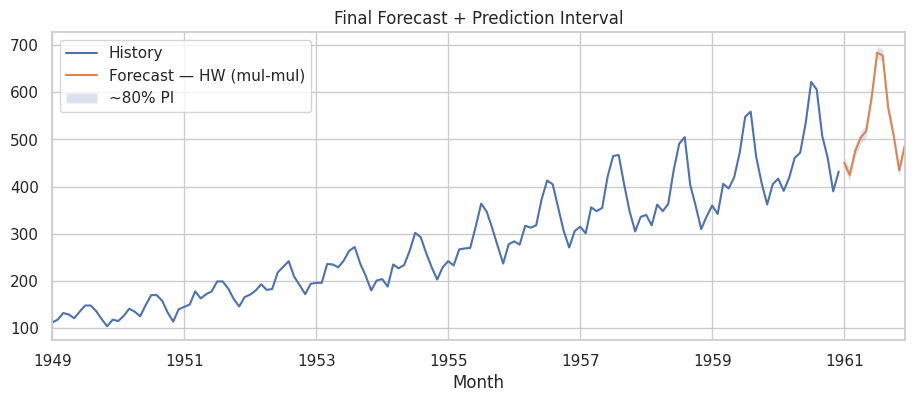

,forecast,lower,upper
1961-01-01,450.676,437.225,464.127
1961-02-01,424.819,411.368,438.270
1961-03-01,475.495,462.044,488.946
1961-04-01,504.076,490.625,517.527
1961-05-01,517.872,504.421,531.323
1961-06-01,590.146,576.695,603.597
1961-07-01,684.227,670.776,697.678
1961-08-01,678.031,664.580,691.482
1961-09-01,567.112,553.661,580.563
1961-10-01,507.824,494.373,521.275


In [10]:
n_forecast = 12

if sarima_score1 is not None and scoreboard1.iloc[0]["Model"].startswith("SARIMA"):
    final1 = SARIMAX(y1, order=best_order1, seasonal_order=best_seasonal1,
                     enforce_stationarity=False, enforce_invertibility=False, trend="n").fit(disp=False)
    res1 = final1.get_forecast(steps=n_forecast)
    fcast1 = res1.predicted_mean; ci1 = res1.conf_int(alpha=0.2)  # 80% PI
    label1 = f"SARIMA {best_order1} x {best_seasonal1}"
else:
    final1 = ExponentialSmoothing(y1, trend="mul", seasonal="mul", seasonal_periods=12).fit()
    fcast1 = final1.forecast(n_forecast)
    resid_std = pd.Series(final1.resid).std()
    ci1 = pd.DataFrame({"lower": fcast1 - 1.28*resid_std, "upper": fcast1 + 1.28*resid_std})
    label1 = "HW (mul-mul)"

plt.figure(figsize=(11,4))
y1.plot(label="History"); fcast1.plot(label=f"Forecast — {label1}")
plt.fill_between(ci1.index, ci1.iloc[:,0], ci1.iloc[:,1], alpha=0.2, label="~80% PI")
plt.title("Final Forecast + Prediction Interval"); plt.legend(); plt.show()

pd.DataFrame({"forecast": fcast1, "lower": ci1.iloc[:,0], "upper": ci1.iloc[:,1]})


# Worked Example 2 — Champagne Sales (Monthly)

Goal: forecast next 12 months. Shorter series; a few 0/NaN quirks → light cleaning.


In [12]:
import pandas as pd
import numpy as np

def load_monthly_series():
    # 1) Champagne (primary)
    url_champagne = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/champagne.csv"
    try:
        raw = pd.read_csv(url_champagne)
        raw.columns = ["Month", "Sales"]
        raw["Month"] = pd.to_datetime(raw["Month"])
        df = raw.set_index("Month").asfreq("MS")
        y = df["Sales"].replace(0, np.nan).interpolate("linear").astype(float)
        name = "Champagne Sales"
        print("Loaded:", name)
        return y, name
    except Exception as e:
        print("Champagne URL failed:", e)

    # 2) A10 dataset fallback (monthly; similar characteristics)
    try:
        url_a10 = "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv"
        raw = pd.read_csv(url_a10)   # columns: date, value
        raw = raw.rename(columns={"date":"Month", "value":"Sales"})
        raw["Month"] = pd.to_datetime(raw["Month"])
        df = raw.set_index("Month").asfreq("MS")
        y = df["Sales"].astype(float)
        name = "A10 Drug Sales (Monthly)"
        print("Loaded:", name)
        return y, name
    except Exception as e:
        print("A10 URL failed:", e)

    # 3) Manual upload (last resort)
    try:
        from google.colab import files
        up = files.upload()  # upload a CSV with columns Month, Sales
        fname = next(iter(up))
        raw = pd.read_csv(fname)
        if "Month" not in raw.columns or "Sales" not in raw.columns:
            raise ValueError("CSV must have columns 'Month' and 'Sales'")
        raw["Month"] = pd.to_datetime(raw["Month"])
        df = raw.set_index("Month").asfreq("MS")
        y = df["Sales"].astype(float)
        name = "User Sales Series (Monthly)"
        print("Loaded:", name)
        return y, name
    except Exception as e:
        raise RuntimeError("Could not load a monthly series. Please check connection or upload a valid CSV.") from e

# ---- call loader ----
y2, series_name2 = load_monthly_series()
print(y2.head(), "\n\nfreq:", y2.index.freq, "\nname:", series_name2)


Champagne URL failed: HTTP Error 404: Not Found
Loaded: A10 Drug Sales (Monthly)
Month
1991-07-01   3.527
1991-08-01   3.181
1991-09-01   3.252
1991-10-01   3.611
1991-11-01   3.566
Freq: MS, Name: Sales, dtype: float64 

freq: <MonthBegin> 
name: A10 Drug Sales (Monthly)


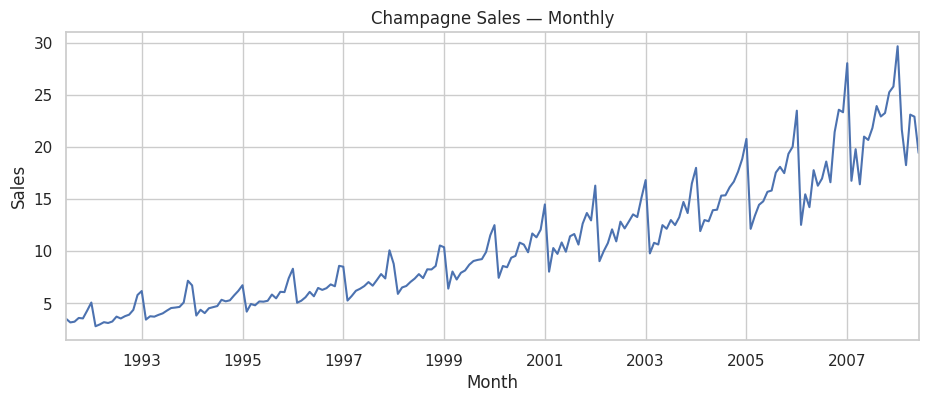

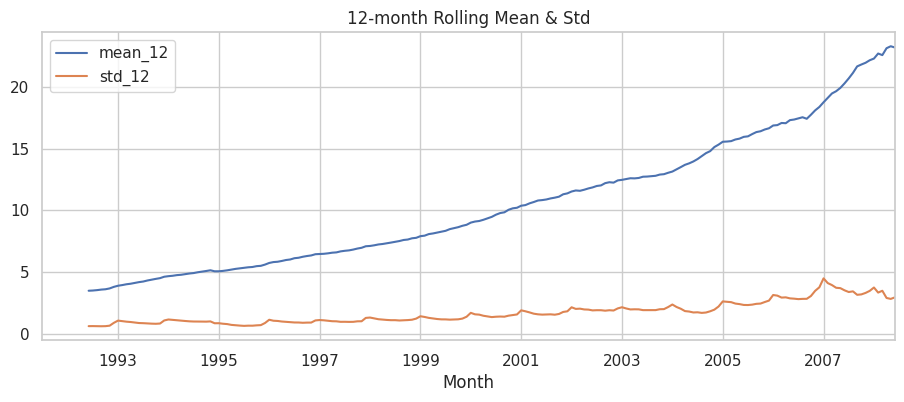

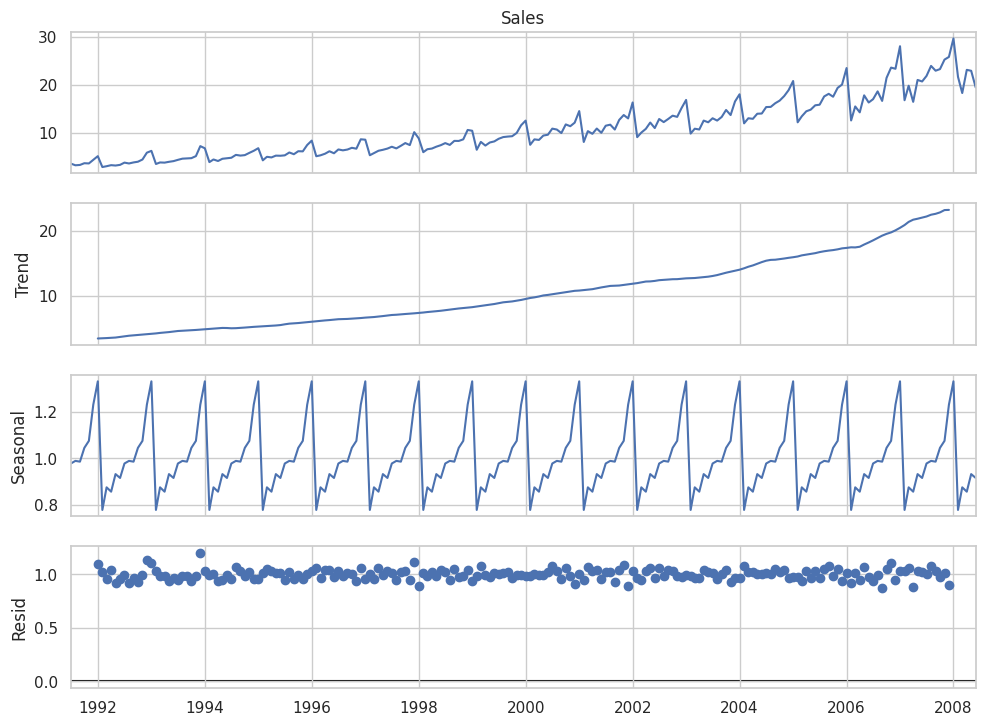

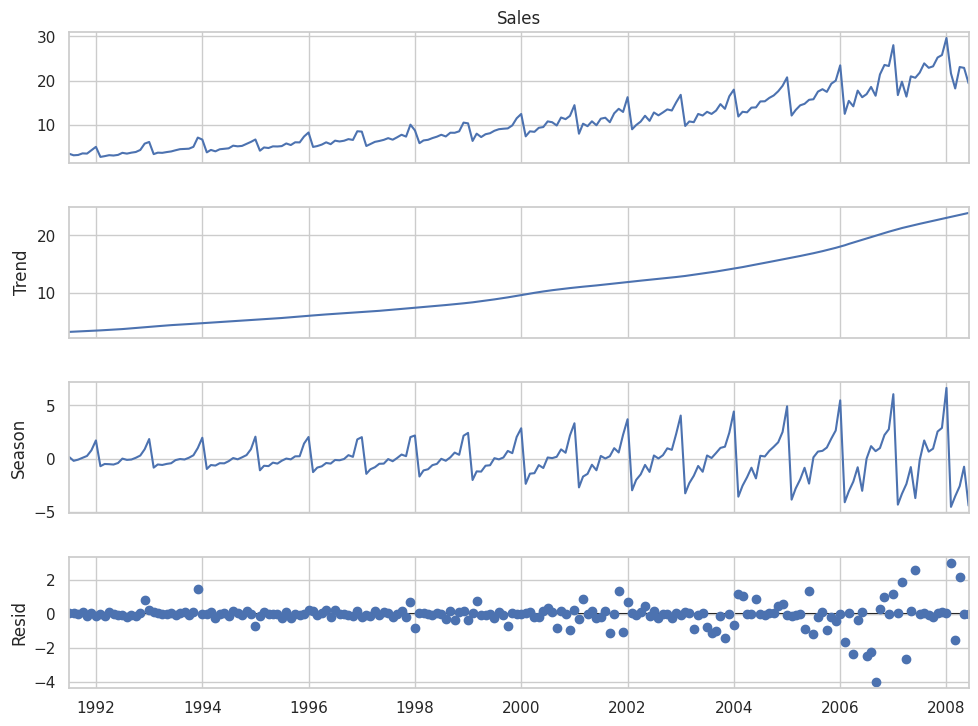

In [13]:
fig, ax = plt.subplots(1,1, figsize=(11,4))
y2.plot(ax=ax); ax.set_title("Champagne Sales — Monthly"); ax.set_ylabel("Sales"); plt.show()

pd.DataFrame({"mean_12": y2.rolling(12).mean(),
              "std_12":  y2.rolling(12).std()}).plot(figsize=(11,4), title="12-month Rolling Mean & Std"); plt.show()

seasonal2 = seasonal_decompose(y2, model="multiplicative", period=12)
seasonal2.plot(); plt.gcf().set_size_inches(11,8); plt.show()

STL(y2, period=12, robust=True).fit().plot(); plt.gcf().set_size_inches(11,8); plt.show()


,Model,MAE,RMSE,MAPE%
0,Naive,3.101,3.772,12.700
1,Seasonal Naive,3.362,3.901,14.681
2,Moving Avg (12),3.374,4.053,13.769


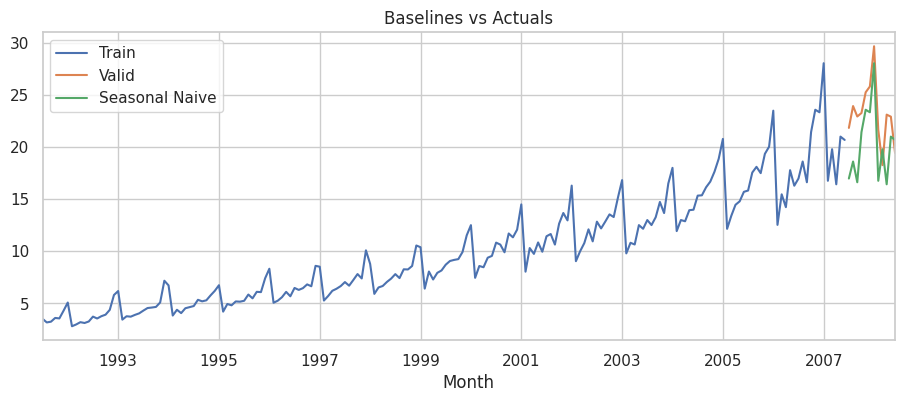

In [14]:
h2 = 12
y2_tr, y2_va = y2.iloc[:-h2], y2.iloc[-h2:]

naive2  = pd.Series(y2_tr.iloc[-1], index=y2_va.index)
snaive2 = y2.shift(12).reindex(y2_va.index)
ma2     = pd.Series(y2_tr.rolling(12).mean().iloc[-1], index=y2_va.index)

baseline_scores2 = pd.concat([
    score(y2_va, naive2, "Naive"),
    score(y2_va, snaive2, "Seasonal Naive"),
    score(y2_va, ma2, "Moving Avg (12)")
], axis=1).T

display(baseline_scores2.sort_values("RMSE"))

plt.figure(figsize=(11,4))
y2_tr.plot(label="Train"); y2_va.plot(label="Valid"); snaive2.plot(label="Seasonal Naive")
plt.title("Baselines vs Actuals"); plt.legend(); plt.show()


,Model,MAE,RMSE,MAPE%
1,"HW (mul trend, mul seas)",1.617,1.998,7.384
2,"HW (mul trend, add seas)",1.985,2.242,9.099
0,Holt (exp trend),2.546,3.228,11.027


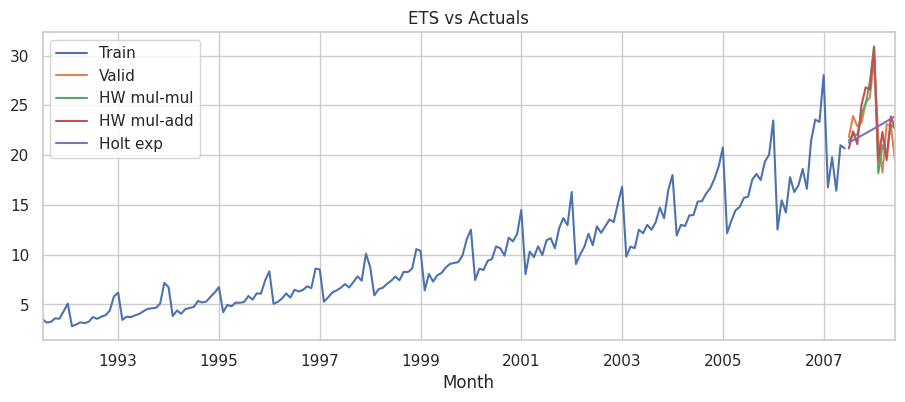

In [15]:
ets_scores2 = []

holt2 = Holt(y2_tr, exponential=True).fit()
pred_holt2 = holt2.forecast(h2)
ets_scores2.append(score(y2_va, pred_holt2, "Holt (exp trend)"))

hw_mm2 = ExponentialSmoothing(y2_tr, trend="mul", seasonal="mul", seasonal_periods=12).fit()
pred_hw_mm2 = hw_mm2.forecast(h2)
ets_scores2.append(score(y2_va, pred_hw_mm2, "HW (mul trend, mul seas)"))

hw_ma2 = ExponentialSmoothing(y2_tr, trend="mul", seasonal="add", seasonal_periods=12).fit()
pred_hw_ma2 = hw_ma2.forecast(h2)
ets_scores2.append(score(y2_va, pred_hw_ma2, "HW (mul trend, add seas)"))

ets_scores2 = pd.DataFrame(ets_scores2).sort_values("RMSE")
display(ets_scores2)

plt.figure(figsize=(11,4))
y2_tr.plot(label="Train"); y2_va.plot(label="Valid")
pred_hw_mm2.plot(label="HW mul-mul"); pred_hw_ma2.plot(label="HW mul-add"); pred_holt2.plot(label="Holt exp")
plt.title("ETS vs Actuals"); plt.legend(); plt.show()


,order,seasonal_order,AIC
93,"(1, 0, 2)","(1, 0, 1)",383.873
165,"(2, 0, 2)","(1, 0, 1)",385.872
157,"(2, 0, 1)","(1, 0, 1)",387.362
45,"(0, 1, 2)","(1, 0, 1)",391.949
109,"(1, 1, 1)","(1, 0, 1)",392.169
189,"(2, 1, 2)","(1, 0, 1)",392.541
117,"(1, 1, 2)","(1, 0, 1)",392.980
181,"(2, 1, 1)","(1, 0, 1)",394.413
149,"(2, 0, 0)","(1, 0, 1)",394.574
85,"(1, 0, 1)","(1, 0, 1)",394.880


,0
Model,"SARIMA (1, 0, 2) x (1, 0, 1, 12)"
MAE,1.635
RMSE,2.120
MAPE%,7.500


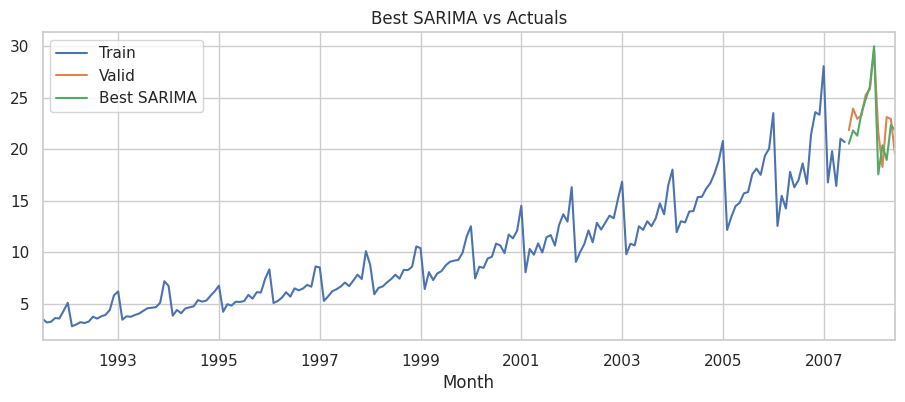

In [16]:
best_sarima2, best_order2, best_seasonal2, tried2 = sarima_search(y2_tr, seasonal_period=12)
display(tried2.head(10))

if best_sarima2 is None:
    print("No SARIMA converged; using ETS only.")
    sarima_pred2 = None
    sarima_score2 = None
else:
    sarima_pred2 = best_sarima2.forecast(h2)
    sarima_score2 = score(y2_va, sarima_pred2, f"SARIMA {best_order2} x {best_seasonal2}")
    display(sarima_score2)

    plt.figure(figsize=(11,4))
    y2_tr.plot(label="Train"); y2_va.plot(label="Valid"); sarima_pred2.plot(label="Best SARIMA")
    plt.title("Best SARIMA vs Actuals"); plt.legend(); plt.show()


,Model,MAE,RMSE,MAPE%
0,"HW (mul trend, mul seas)",1.617,1.998,7.384
1,"SARIMA (1, 0, 2) x (1, 0, 1, 12)",1.635,2.120,7.500
2,"HW (mul trend, add seas)",1.985,2.242,9.099
3,Holt (exp trend),2.546,3.228,11.027
4,Naive,3.101,3.772,12.700
5,Seasonal Naive,3.362,3.901,14.681
6,Moving Avg (12),3.374,4.053,13.769


Diagnostics: HW mul-mul


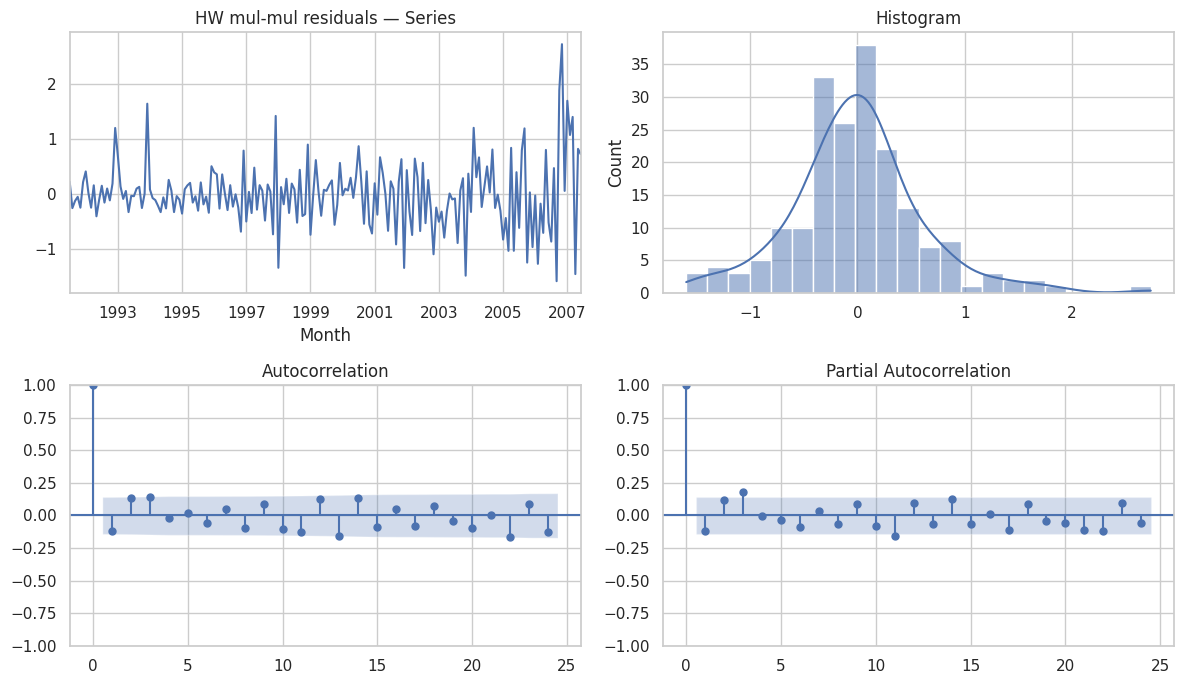

Ljung–Box p-values:
     lb_stat  lb_pvalue
12   23.493      0.024
24   50.365      0.001


In [17]:
cands2 = [baseline_scores2, ets_scores2]
if sarima_score2 is not None:
    cands2.append(pd.DataFrame([sarima_score2]))
scoreboard2 = pd.concat(cands2).sort_values("RMSE").reset_index(drop=True)
display(scoreboard2)

if sarima_score2 is not None and scoreboard2.iloc[0]["Model"].startswith("SARIMA"):
    print("Diagnostics: SARIMA")
    residual_diagnostics(best_sarima2.resid, idx=y2_tr.index, lags=24, title="SARIMA residuals")
else:
    print("Diagnostics: HW mul-mul")
    residual_diagnostics(hw_mm2.resid, idx=y2_tr.index, lags=24, title="HW mul-mul residuals")


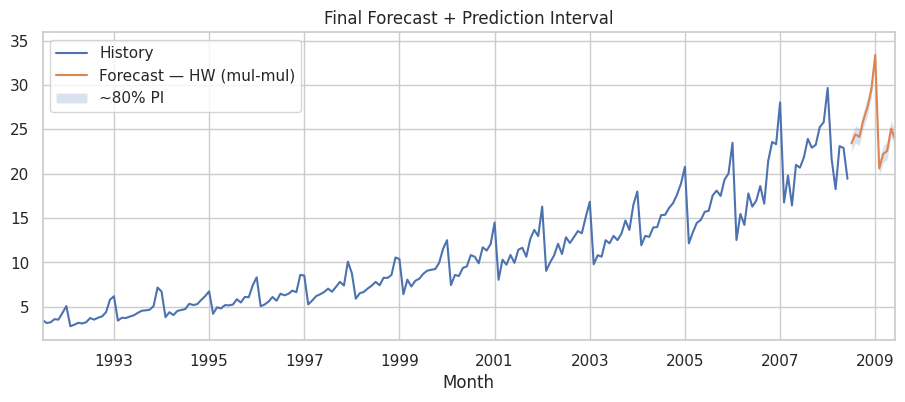

,forecast,lower,upper
2008-07-01,23.428,22.451,24.405
2008-08-01,24.434,23.457,25.411
2008-09-01,24.144,23.167,25.121
2008-10-01,26.049,25.072,27.026
2008-11-01,27.436,26.459,28.413
2008-12-01,29.429,28.452,30.406
2009-01-01,33.389,32.412,34.366
2009-02-01,20.594,19.617,21.571
2009-03-01,22.232,21.255,23.209
2009-04-01,22.567,21.590,23.544


In [18]:
n_forecast2 = 12

if sarima_score2 is not None and scoreboard2.iloc[0]["Model"].startswith("SARIMA"):
    final2 = SARIMAX(y2, order=best_order2, seasonal_order=best_seasonal2,
                     enforce_stationarity=False, enforce_invertibility=False, trend="n").fit(disp=False)
    res2 = final2.get_forecast(steps=n_forecast2)
    fcast2 = res2.predicted_mean; ci2 = res2.conf_int(alpha=0.2)
    label2 = f"SARIMA {best_order2} x {best_seasonal2}"
else:
    final2 = ExponentialSmoothing(y2, trend="mul", seasonal="mul", seasonal_periods=12).fit()
    fcast2 = final2.forecast(n_forecast2)
    resid_std2 = pd.Series(final2.resid).std()
    ci2 = pd.DataFrame({"lower": fcast2 - 1.28*resid_std2, "upper": fcast2 + 1.28*resid_std2})
    label2 = "HW (mul-mul)"

plt.figure(figsize=(11,4))
y2.plot(label="History"); fcast2.plot(label=f"Forecast — {label2}")
plt.fill_between(ci2.index, ci2.iloc[:,0], ci2.iloc[:,1], alpha=0.2, label="~80% PI")
plt.title("Final Forecast + Prediction Interval"); plt.legend(); plt.show()

pd.DataFrame({"forecast": fcast2, "lower": ci2.iloc[:,0], "upper": ci2.iloc[:,1]})


## Wrap-up

- Airline: strong multiplicative seasonality; HW (mul-mul) or SARIMA typically wins vs Seasonal Naive.  
- Champagne: shorter, noisier; light cleaning helps; HW often competitive.  
- Always compare to baselines, run residual diagnostics, and report prediction intervals.
